In [21]:
import json
import networkx as nx
import os
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import importlib
import utils.graph_builder as graph_builder
import utils.graph_queries as graph_queries
import utils.sentiment_utils as sentiment_utils

<module 'utils.sentiment_utils' from '/home/max/Documents/uni/SGI/src/utils/sentiment_utils.py'>

## Build graph:

In [3]:
file = "uk_parliament_interactions_graph_data_V4.json"

In [4]:
G = graph_builder.build_full_graph(file)

## Import Sentiment Word List

In [2]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [5]:
labMT_wordlist = pd.read_csv("LabMT_wordlist.txt", sep="\t", skiprows=2) 
sentiment_values_dict = {}

for word in labMT_wordlist["word"]:
    if (word not in stop_words) and (len(word) > 2):
        sentiment_values_dict[word] = float(labMT_wordlist.loc[labMT_wordlist["word"] == word, "happiness_average"].iloc[0])

## Sentiment distribution around different politicians:

In [7]:
average_politician_sentiment = graph_queries.calculate_all_politicians_average_sentiment(G, sentiment_values_dict)
arr_sentiments = np.array(list(average_politician_sentiment.values()))

0/665
250/665
500/665
665/665


Calculate statistics

In [44]:
mean_val     = np.mean(arr_sentiments)
median_val   = np.median(arr_sentiments)
variance_val = np.var(arr_sentiments)
std_val      = np.std(arr_sentiments)

print(f"Average: {mean_val:.3f}")
print(f"Median: {median_val:.3f}")
print(f"Variance: {variance_val:.3f}")
print(f"std: {std_val:.3f}")

Average: 4.718
Median: 4.718
Variance: 0.015
std: 0.124


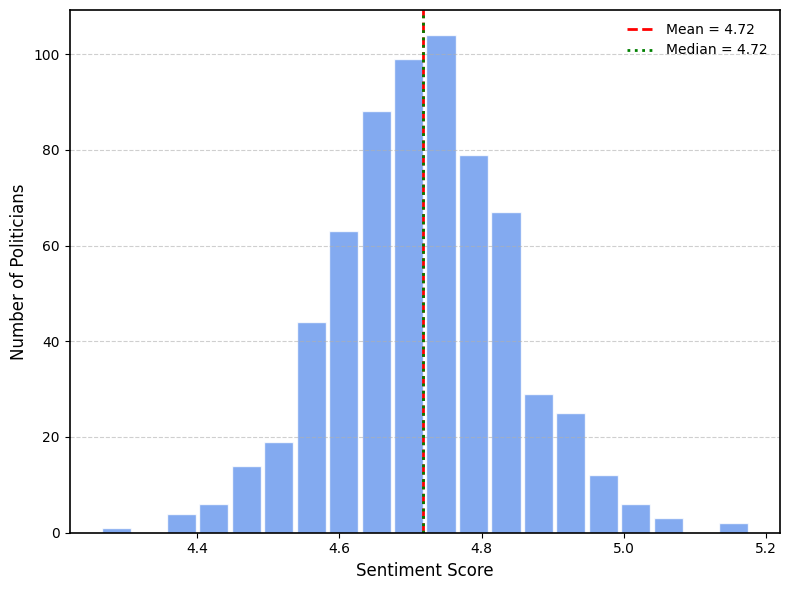

In [168]:
fig, ax = plt.subplots(figsize=(8, 6))

n, bins, patches = ax.hist(
    arr_sentiments,
    bins=20,
    color="cornflowerblue",
    edgecolor="white",
    alpha=0.8,
    rwidth=0.9
)

# Add mean and median lines
ax.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.2f}")
ax.axvline(median_val, color="green", linestyle=":", linewidth=2, label=f"Median = {median_val:.2f}")

ax.set_title("Distribution of Politicians Average Sentiment", fontsize=14, fontweight="bold", pad=12)
ax.set_xlabel("Sentiment Score", fontsize=12)
ax.set_ylabel("Number of Politicians", fontsize=12)

ax.grid(axis="y", linestyle="--", alpha=0.6)
for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    spine.set_visible(True)

ax.legend(frameon=False, fontsize=10)
plt.tight_layout()

plt.show()

# Comparing average interaction sentiment vs interaction sentiment with extreme sentiment politicians

Getting the 30 politicians with the closest sentiment to the overall average sentiment

In [169]:
n = 30

In [170]:
middle_30_politicians = sorted(
    average_politician_sentiment.items(), 
    key=lambda x: abs(x[1] - mean_val))

top_30_neutral_politicians = middle_30_politicians[:n]

Getting the top 30 happiest and saddest politicians

In [171]:
sorted_politicians = sorted(average_politician_sentiment.items(), key=lambda x: x[1], reverse=True)

In [172]:
top_30_happiest_politicians = sorted_politicians[:n]
top_30_saddest_politicians  = sorted_politicians[-n:]

There's not enough data to compare how each particular politicians interacts with the more "extreme" politicians, as for the sentiment analysis to be robust the text measured has to have more than a couple interactions:

"as with any sentiment analysis technique, our instrument is fallible for smaller texts, especially at the scale of a typical sentence, where ambiguity may render even human readers unable to judge meaning or tone"  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#s1

Therefore all contributions against each "extreme" politician are analyzed as a hole.

Sentiment when interacting with top **neutral** politicians: 

In [173]:
sentiment_against_top_neutral = graph_queries.calc_avg_sentiment_against_extreme_politicians_list(G, top_30_neutral_politicians, sentiment_values_dict)

sentiment_against_top_neutral = np.array(sentiment_against_top_neutral)
mean_neutral = np.mean(sentiment_against_top_neutral)
std_neutral = np.std(sentiment_against_top_neutral)
n_neutral = len(sentiment_against_top_neutral)

print(f"Average: {mean_neutral:.3f}")
print(f"std: {std_neutral:.3f}")
print(f"n: {n_neutral}")

Average: 4.718
std: 0.069
n: 30


Sentiment when interacting with top **happiest** politicians: 

In [174]:
sentiment_against_top_happiest = graph_queries.calc_avg_sentiment_against_extreme_politicians_list(G, top_30_happiest_politicians, sentiment_values_dict)

sentiment_against_top_happiest = np.array(sentiment_against_top_happiest)
mean_happy = np.mean(sentiment_against_top_happiest)
std_happy = np.std(sentiment_against_top_happiest)
n_happy = len(sentiment_against_top_happiest)

print(f"Average: {mean_happy:.3f}")
print(f"std: {std_happy:.3f}")
print(f"n: {n_happy}")

Average: 4.828
std: 0.070
n: 29


Sentiment when interacting with top **saddest** politicians: 

In [175]:
sentiment_against_top_saddest = graph_queries.calc_avg_sentiment_against_extreme_politicians_list(G, top_30_saddest_politicians, sentiment_values_dict)

sentiment_against_top_saddest = np.array(sentiment_against_top_saddest)
mean_sad = np.mean(sentiment_against_top_saddest)
std_sad = np.std(sentiment_against_top_saddest)
n_sad = len(sentiment_against_top_saddest)

print(f"Average: {mean_sad:.3f}")
print(f"std: {std_sad:.3f}")
print(f"n: {n_sad}")

Average: 4.674
std: 0.095
n: 27


In [176]:
print(f"{'Group':<10} {'Mean':>8} {'Std Dev':>10} {'N':>6}")
print("-" * 40)
print(f"{'Neutral':<10} {mean_neutral:>8.3f} {std_neutral:>10.3f} {n_neutral:>6}")
print(f"{'Happy':<10} {mean_happy:>8.3f} {std_happy:>10.3f} {n_happy:>6}")
print(f"{'Sad':<10} {mean_sad:>8.3f} {std_sad:>10.3f} {n_sad:>6}")


Group          Mean    Std Dev      N
----------------------------------------
Neutral       4.718      0.069     30
Happy         4.828      0.070     29
Sad           4.674      0.095     27


Implementing a t-test:

In [177]:
def welch_ttest(mean1, std1, n1, mean2, std2, n2, alternative):
    # t-statistic
    t_stat = (mean1 - mean2) / np.sqrt(std1**2/n1 + std2**2/n2)

    # degrees of freedom 
    df = ((std1**2/n1 + std2**2/n2)**2) / \
         ((std1**2/n1)**2/(n1-1) + (std2**2/n2)**2/(n2-1))

    if alternative == "greater":
        p_value = 1 - stats.t.cdf(t_stat, df=df)
        
    elif alternative == "less":
        p_value = stats.t.cdf(t_stat, df=df)
        
    else:  
        p_value = (1 - stats.t.cdf(abs(t_stat), df=df)) * 2

    return t_stat, df, p_value

Testing whether sentiment is **higher** when interacting with **happy** MPs than with **neutral** MPs.

In [178]:
t_stat, df, p_value = welch_ttest(mean_happy, std_happy, n_happy, mean_neutral, std_neutral, n_neutral, "greater")
confidence_level = 1 - p_value

print(f"t = {t_stat:.3f}, df = {df:.2f}, p_value = {p_value:.5f}")
print(f"Confidence level: {confidence_level*100:.2f}%")

t = 6.062, df = 56.85, p_value = 0.00000
Confidence level: 100.00%


Testing whether sentiment is **lower** when interacting with **sadd** MPs than with **neutral** MPs.

In [179]:
t_stat, df, p_value = welch_ttest(mean_sad, std_sad, n_sad, mean_neutral, std_neutral, n_neutral, "less")
confidence_level = 1 - p_value

print(f"t = {t_stat:.3f}, df = {df:.2f}, p_value = {p_value:.5f}")
print(f"Confidence level: {confidence_level*100:.2f}%")

t = -1.976, df = 47.14, p_value = 0.02703
Confidence level: 97.30%


## Average Sentiment Trend

Gathering interactions data by time:

In [180]:
dates = []
contributions = []
member_id_list = []

for member_id in list(G.nodes):
    for edge in list(G.out_edges(member_id, data=True)):
        edge_data = edge[2]    
    
        for interaction in edge_data["interactions"]:
            dates          += [interaction["debate_data"]["debate_date"]] * 2
            contributions  += list(interaction["utterances"].values())
            member_id_list += list(interaction["utterances"].keys())


In [181]:
df = pd.DataFrame({"Date": pd.to_datetime(dates), "Contributions": contributions, "Member_id" : member_id_list})
df

,Date,Contributions,Member_id
0,2020-11-25,"I beg to move, That this House has considered ...",4097
1,2020-11-25,"The right hon. Lady is right in one respect, b...",318
2,2020-11-25,I observe that the right hon. Gentleman did su...,4097
3,2020-11-25,"On the quantification of future benefits, of c...",4615
4,2020-09-24,I certainly agree that healthcare is the big i...,4097
...,...,...,...
172073,2021-06-16,I thank my right hon. Friend for the assistanc...,4759
172074,2021-06-16,"First, I am very grateful to the hon. Member f...",4095
172075,2021-06-16,"East Devon is back open for business, but step...",4862
172076,2023-10-17,We are making the most significant public heal...,4095


Grouping interactions every 2 months and calculating the average sentiment:

In [222]:
df_grouped = df.groupby(pd.Grouper(key="Date", freq="2ME"))["Contributions"].apply(list).reset_index()

In [223]:
sentiment_values_list = []
for i, period in df_grouped.iterrows():
    contributions = period["Contributions"]
    sentiment_value = sentiment_utils.calculate_text_list_sentiment(contributions, sentiment_values_dict)

    sentiment_values_list.append(sentiment_value)

In [224]:
df_grouped["avg_sentiment"] = sentiment_values_list

Plotting the trend:

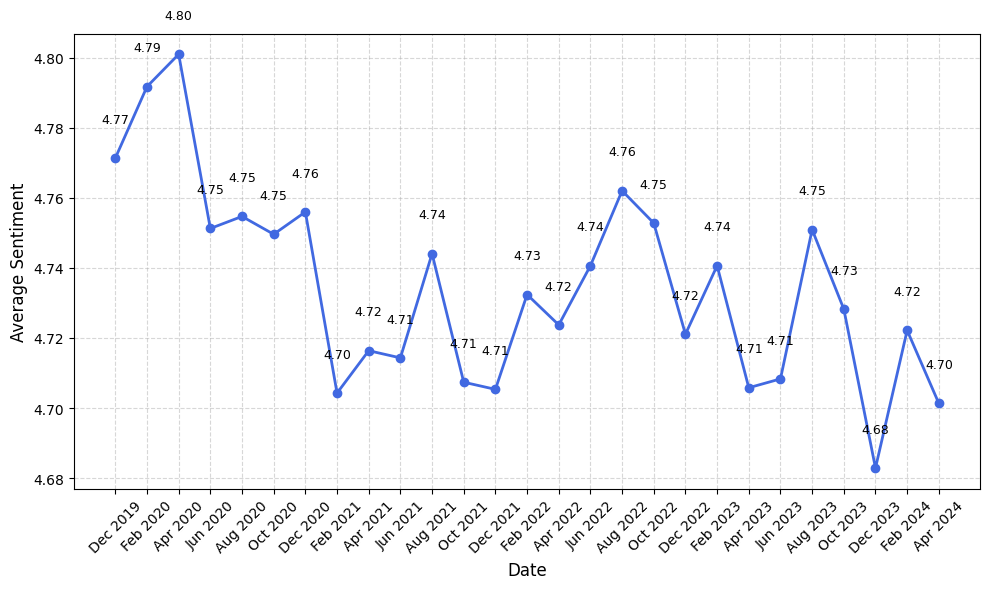

In [232]:
df_grouped["Date_label"] = df_grouped["Date"].dt.strftime("%b %Y")

plt.figure(figsize=(10, 6))
plt.plot(df_grouped["Date_label"], df_grouped["avg_sentiment"], marker='o', linestyle='-', color='royalblue', linewidth=2)

# plt.title("Average Sentiment Evolution", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment", fontsize=12)

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

for x, y in zip(df_grouped["Date_label"], df_grouped["avg_sentiment"]):
    plt.text(x, y + 0.01, f"{y:.2f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### Average Sentiment Trend on politician with the most interactions

Politicians with the most interactions:

In [221]:
df["Member_id"].value_counts().head(1)

Member_id
1423    3343
Name: count, dtype: int64

In [220]:
G.nodes[1423]["DisplayAs"]

'Boris Johnson'

Group interactions every 5 months:

In [213]:
df_boris_johnson = df.loc[df["Member_id"] == 1423].copy()
df_boris_johnson = df_boris_johnson.groupby(pd.Grouper(key="Date", freq="5ME"))["Contributions"].apply(list).reset_index()

In [219]:
sentiment_values_boris_list = []

for i, period in df_boris_johnson.iterrows():
    contributions = period["Contributions"]
    sentiment_value = sentiment_utils.calculate_text_list_sentiment(contributions, sentiment_values_dict)

    sentiment_values_boris_list.append(sentiment_value)

df_boris_johnson["avg_sentiment"] = sentiment_values_boris_list

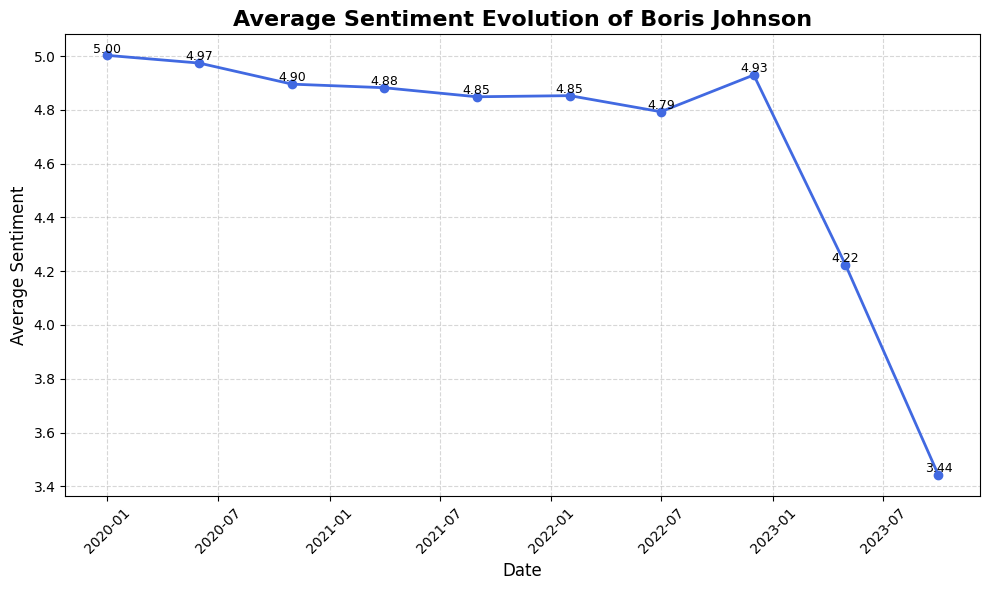

In [218]:
plt.figure(figsize=(10, 6))
plt.plot(df_boris_johnson["Date"], df_boris_johnson["avg_sentiment"], marker='o', linestyle='-', color='royalblue', linewidth=2)

plt.title("Average Sentiment Evolution of Boris Johnson", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment", fontsize=12)

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

for x, y in zip(df_boris_johnson["Date"], df_boris_johnson["avg_sentiment"]):
    plt.text(x, y + 0.01, f"{y:.2f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()